# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix,roc_auc_score,log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb 
seed = 4353

/home/sudhir/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load data set

In [89]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Explore data set

In [90]:
print('Number of rows and columns in data set',train.shape)
train.head()

Number of rows and columns in data set (19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
print('Number of rows and columns in data set',test.shape)
test.head()

Number of rows and columns in data set (8392, 2)


,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


# Authors Target variable distribution

In [91]:
train['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

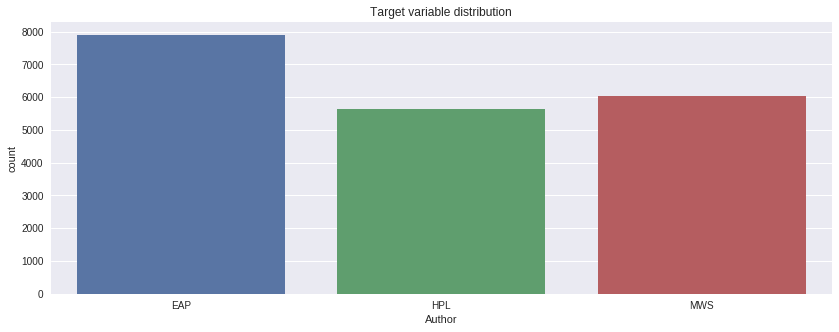

In [92]:
plt.figure(figsize=(14,5))
sns.countplot(train['author'],)
plt.xlabel('Author')
plt.title('Target variable distribution')
plt.show()

# Text cleaning

## Remove unwanted punctuation mark

In [27]:
print('Original text:\n',train['text'][0])
review = re.sub('[^A-Za-z0-9]'," ",train['text'][0]) 
print('\nAfter removal of punctuation:\n',review)

Original text:
 This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.

After removal of punctuation:
 This process  however  afforded me no means of ascertaining the dimensions of my dungeon  as I might make its circuit  and return to the point whence I set out  without being aware of the fact  so perfectly uniform seemed the wall 


# Split sentence into word

In [44]:
review = word_tokenize(train['text'][0]) 
print('Word Tokenize:\n',review)

review = [word for word in str(train['text'][0]).lower().split() if  word not in set(stopwords.words('english'))]
print('\nRemoval of Stopwords:\n',review)

review = [word for word in str(train['text'][0]).lower().split() if  word in set(stopwords.words('english'))]
print('\nStopwords in the sentence:\n',review)

ps = PorterStemmer()
review = [ps.stem(word) for word in str(train['text'][0]).lower().split()]
print('\nStemming of word:\n',review)

Word Tokenize:
 ['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']

Removal of Stopwords:
 ['process,', 'however,', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon;', 'might', 'make', 'circuit,', 'return', 'point', 'whence', 'set', 'out,', 'without', 'aware', 'fact;', 'perfectly', 'uniform', 'seemed', 'wall.']

Stopwords in the sentence:
 ['this', 'me', 'no', 'of', 'the', 'of', 'my', 'as', 'i', 'its', 'and', 'to', 'the', 'i', 'being', 'of', 'the', 'so', 'the']

Stemming of word:
 ['thi', 'process,', 'however,', 'afford', 'me', 'no', 'mean', 'of', 'ascertain', 'the', 'dimens', 'of', 'my', 'dungeon;', 'as', 'i', 'might', 'make', 'it', 'circuit,', 'a

# Function for text cleaning

In [93]:
def clean_text(df):
    ps = PorterStemmer()
    corpus = []
    for i in range(0, df.shape[0]):        
        review = re.sub('[^A-Za-z0-9]'," ",df['text'][i])
        review = word_tokenize(review)        
        review = [word for word in review if word.lower() not in set(stopwords.words('english'))]
        review = [ps.stem(word) for word in review]
        review = ' '.join(review)
        corpus.append(review)
    
    return corpus

In [94]:
corp_train = clean_text(train)
corp_test = clean_text(test)
train['clean_text'] = corp_train
test['clean_text'] = corp_test
del corp_train,corp_test

KeyboardInterrupt: 

# Determine length of text

In [95]:
def text_len(df):
    #i = ['text']
    df['num_words'] = df['text'].apply(lambda x: len(str(x).split()))
    df['num_uniq_words'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['num_chars'] = df['text'].apply(lambda x: len(str(x)))
    df['num_stopwords'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() 
                                                          if w in set(stopwords.words('english'))]))
    df['num_punctuations'] = df['text'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))
    df['num_words_upper'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df['num_words_title'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['mean_word_len'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

text_len(train)
text_len(test)

# Data analysis

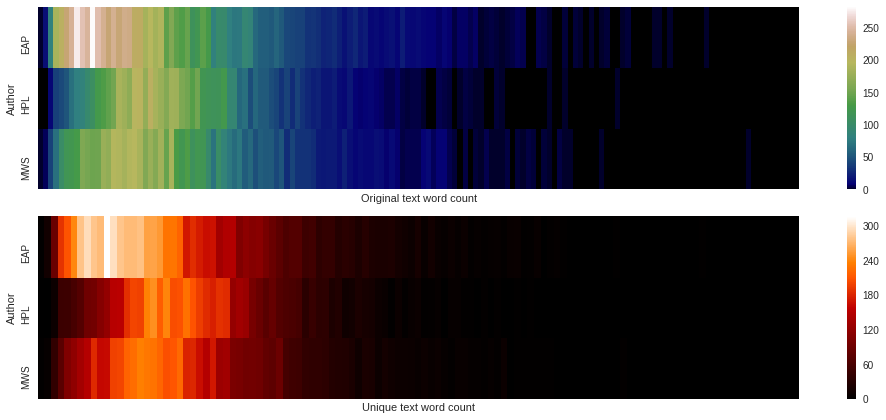

In [160]:
plt.figure(figsize=(14,6))
plt.subplot(211)
sns.heatmap(pd.crosstab(train['author'],train['num_words']),cmap='gist_earth',xticklabels=False)
plt.xlabel('Original text word count')
plt.ylabel('Author')

plt.subplot(212)
sns.heatmap(pd.crosstab(train['author'],train['num_uniq_words']),cmap='gist_heat',xticklabels=False)
plt.xlabel('Unique text word count')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

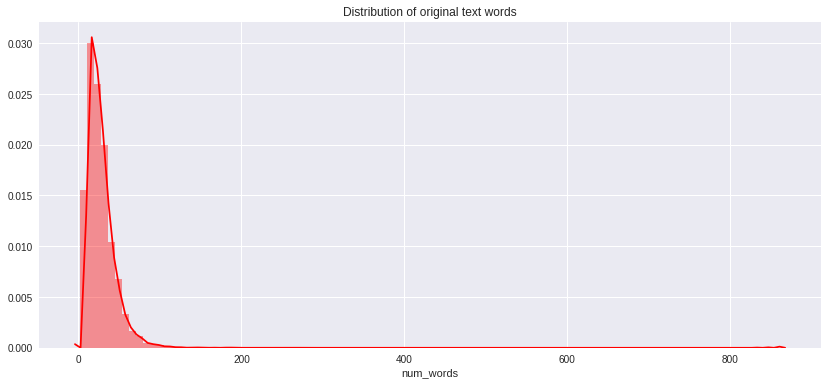

In [52]:
plt.figure(figsize=(14,6))
sns.distplot(train['num_words'],bins=100,color='r')
plt.title('Distribution of original text words')
plt.show()

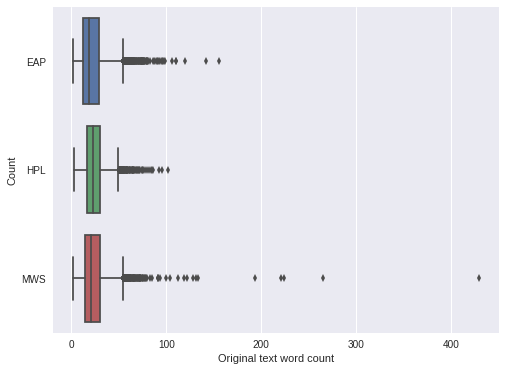

In [185]:
#fig,ax = plt.subplots(figsize=(14,6))
fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(y=train['author'],x=train['num_uniq_words'])
plt.xlabel('Original text word count')
plt.ylabel('Count')
plt.show()

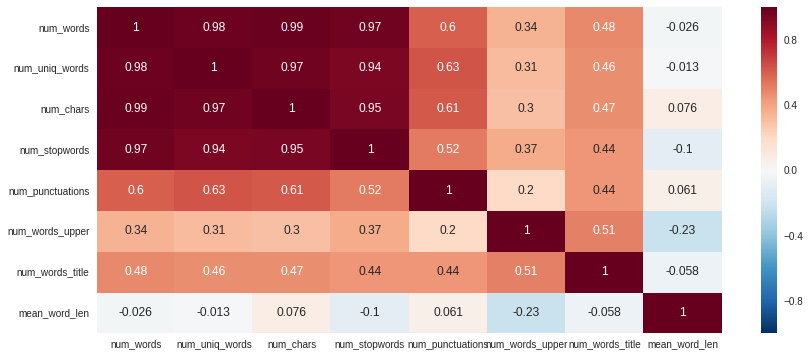

In [101]:
plt.figure(figsize=(14,6))
sns.heatmap(train.corr(),annot=True)
plt.show()

# Bag of words

In [6]:
cv =CountVectorizer(max_features=2000,ngram_range=(1,3),dtype=np.int8,stop_words='english')
X_cv = cv.fit_transform(train['clean_text']).toarray()
X_test_cv = cv.fit_transform(test['clean_text']).toarray()

# Encoder

In [7]:
author_name = {'EAP':0,'HPL':1,'MWS':2}
y = train['author'].map(author_name) 

# Naive Bayes classifier

In [81]:
mNB = MultinomialNB()

kf = KFold(n_splits=10,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score = []
i=1
for train_index,test_index in kf.split(X_cv):
    print('{} of KFlod {}'.format(i,kf.n_splits))    
    xtr,xvl = X_cv[train_index], X_cv[test_index]
    ytr,yvl = y[train_index], y[test_index]
    
    mNB.fit(xtr,ytr)
    y_mNB = mNB.predict(xvl)
    cv_score.append(log_loss(yvl,mNB.predict_proba(xvl)))
    print(cv_score[i-1])
    pred_test_full += mNB.predict_proba(X_test_cv)
    i+=1
#roc_auc_score(yvl,mNB.predict_proba(xvl)[:,1]) # not for multi class
print('confusion matrix:\n',confusion_matrix(yvl,y_mNB))
print(cv_score)
print('Mean accuracy score',np.mean(cv_score))
del xtr,ytr,xvl,yvl

1 of KFlod 10
confusion matrix:
 [[633  65  90]
 [ 49 488  40]
 [ 50  31 512]]
2 of KFlod 10
confusion matrix:
 [[617  56  98]
 [ 60 467  42]
 [ 71  20 527]]
3 of KFlod 10
confusion matrix:
 [[666  61  77]
 [ 64 460  33]
 [ 49  34 514]]
4 of KFlod 10
confusion matrix:
 [[612  65  98]
 [ 69 476  36]
 [ 52  30 520]]
5 of KFlod 10
confusion matrix:
 [[637  60 120]
 [ 59 427  48]
 [ 64  37 506]]
6 of KFlod 10
confusion matrix:
 [[579  72  97]
 [ 57 463  49]
 [ 51  31 559]]
7 of KFlod 10
confusion matrix:
 [[626  62  96]
 [ 56 476  32]
 [ 54  42 514]]
8 of KFlod 10
confusion matrix:
 [[648  73  89]
 [ 66 452  35]
 [ 53  30 512]]
9 of KFlod 10
confusion matrix:
 [[644  64  87]
 [ 62 488  33]
 [ 57  27 496]]
10 of KFlod 10
confusion matrix:
 [[654  54 100]
 [ 61 450  37]
 [ 60  24 517]]
[0.43802893187908998, 0.47005769909790696, 0.46203863765728947, 0.51403631672037564, 0.51103671794144478, 0.52358229507830745, 0.45667863805634562, 0.49930542709753856, 0.45524845716739804, 0.47566741573148069

#  Submit prediction for unseen dataset

In [ ]:
y_pred = pred_test_full/10
submit = pd.DataFrame(test['id'])
submit = submit.join(pd.DataFrame(y_pred))
submit.columns = ['id','EAP','HPL','MWS'] 
#submit.to_csv('spooky_pred1.csv.gz',index=False,compression='gzip')
submit.to_csv('spooky_pred1.csv',index=False)

# TfIdf  (Term frequency Inverse document frequency)

In [74]:
tfidf = TfidfVectorizer(max_features=5000,dtype=np.float32,analyzer='word',
                        ngram_range=(1, 3),use_idf=True, smooth_idf=True, 
                        sublinear_tf=True)
X_tf = tfidf.fit_transform(train['clean_text']).toarray()
X_test_tf = tfidf.fit_transform(test['clean_text']).toarray()

# Naive Bayes classifier

In [75]:
mNB = MultinomialNB()

kf = KFold(n_splits=10,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score = []
i=1
for train_index,test_index in kf.split(X_tf):
    print('{} of KFlod {}'.format(i,kf.n_splits))    
    xtr,xvl = X_tf[train_index], X_tf[test_index]
    ytr,yvl = y[train_index], y[test_index]
    
    mNB.fit(xtr,ytr)
    y_mNB = mNB.predict(xvl)
    cv_score.append(log_loss(yvl,mNB.predict_proba(xvl))) 
    print(cv_score[i-1])
    pred_test_full += mNB.predict_proba(X_test_tf)
    i+=1
#roc_auc_score(yvl,mNB.predict_proba(xvl)[:,1]) # not for multi class
print('confusion matrix:\n',confusion_matrix(yvl,y_mNB))
print(cv_score)
print('Mean accuracy score',np.mean(cv_score))
del xtr,ytr,xvl,yvl

1 of KFlod 10
confusion matrix:
 [[679  40  69]
 [ 96 454  27]
 [ 88  31 474]]
2 of KFlod 10
confusion matrix:
 [[670  40  61]
 [101 432  36]
 [ 95  31 492]]
3 of KFlod 10
confusion matrix:
 [[706  40  58]
 [100 418  39]
 [ 70  38 489]]
4 of KFlod 10
confusion matrix:
 [[663  42  70]
 [ 98 445  38]
 [ 82  30 490]]
5 of KFlod 10
confusion matrix:
 [[675  38 104]
 [ 97 389  48]
 [ 86  33 488]]
6 of KFlod 10
confusion matrix:
 [[641  46  61]
 [104 423  42]
 [ 93  32 516]]
7 of KFlod 10
confusion matrix:
 [[681  29  74]
 [ 82 450  32]
 [ 84  37 489]]
8 of KFlod 10
confusion matrix:
 [[697  48  65]
 [108 412  33]
 [ 87  33 475]]
9 of KFlod 10
confusion matrix:
 [[663  54  78]
 [ 96 449  38]
 [ 81  27 472]]
10 of KFlod 10
confusion matrix:
 [[687  43  78]
 [ 92 419  37]
 [ 93  24 484]]
[0.5649311974774599, 0.57272572061709603, 0.55645250679230651, 0.57309592108387442, 0.58558273547794437, 0.58066095496067005, 0.56736507564929795, 0.57622689581026409, 0.57445875204066166, 0.56929349876497348]

#  Submit prediction for unseen dataset

In [ ]:
y_pred = pred_test_full/10
submit = pd.DataFrame(test['id'])
submit = submit.join(pd.DataFrame(y_pred))
submit.columns = ['id','EAP','HPL','MWS'] 
#submit.to_csv('spooky_pred2.csv.gz',index=False,compression='gzip')
submit.to_csv('spooky_pred2.csv',index=False)

# Merge

In [128]:
#filter data set
unwanted = ['text','id',]
#X_tf = np.concatenate((X_tf,train.drop(unwanted+['author'],axis=1).values),axis=1)
#X_test_tf = np.concatenate((X_test_tf,test.drop(unwanted,axis=1).values),axis=1)

X = train.drop(unwanted+['author'],axis=1).join(pd.DataFrame(X_cv),how='left')
X_test = test.drop(unwanted,axis=1).join(pd.DataFrame(X_test_cv),how='left')
#X = train.drop(unwanted+['author'],axis=1)
#X_test = test.drop(unwanted,axis=1)
print(X.shape)
print(X_test.shape)

(19579, 8)
(8392, 8)


# Xgboost

In [141]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.1,early_stop=20,max_depth=10,n_rounds=100):
    
    params = {        
        'objective':'multi:softprob',
        'learning_rate':eta,
        'max_depth':max_depth,
        'num_class':3,
        'subsample':0.7,
        'colsample_bytree':0.7,
        'eval_metric':'mlogloss',
        'min_child_weight':1,        
        #'verbose':0,
        'seed':seed,        
        'n_thread':-1 }
    
    #plst = list(params.items())
    dtrain =xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)    
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,n_rounds,evals=watchlist,early_stopping_rounds=early_stop,verbose_eval=30)
    pred = model.predict(dvalid,ntree_limit = model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit = model.best_ntree_limit)
    
    return pred_test,model

In [140]:
kf = KFold(n_splits=10,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score = []
i=1
for train_index,test_index in kf.split(X):
    print('{} of KFlod {}'.format(i,kf.n_splits))    
    xtr,xvl = X.loc[train_index], X.loc[test_index]
    ytr,yvl = y[train_index], y[test_index]
        
    pred_xgb,xg_model = runXGB(xtr,xvl,ytr,yvl,X_test,n_rounds=500)
    pred_test_full += pred_xgb
    i+=1
#roc_auc_score(yvl,mNB.predict_proba(xvl)[:,1]) # not for multi class
#print(cv_score)
#print('Mean accuracy score',np.mean(cv_score))
#del xtr,ytr,xvl,yvl,X_tf,X_test_tf

1 of KFlod 10
[0]	train-mlogloss:1.08549	test-mlogloss:1.08906
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[30]	train-mlogloss:0.924146	test-mlogloss:0.990551
[60]	train-mlogloss:0.867343	test-mlogloss:0.983447
Stopping. Best iteration:
[56]	train-mlogloss:0.873327	test-mlogloss:0.982839

2 of KFlod 10
[0]	train-mlogloss:1.08541	test-mlogloss:1.08933
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[30]	train-mlogloss:0.920937	test-mlogloss:1.00268
[60]	train-mlogloss:0.866224	test-mlogloss:0.993219
[90]	train-mlogloss:0.831784	test-mlogloss:0.993859
Stopping. Best iteration:
[76]	train-mlogloss:0.846379	test-mlogloss:0.992169

3 of KFlod 10
[0]	train-mlogloss:1.0856	test-mlogloss:1.08881
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Wil

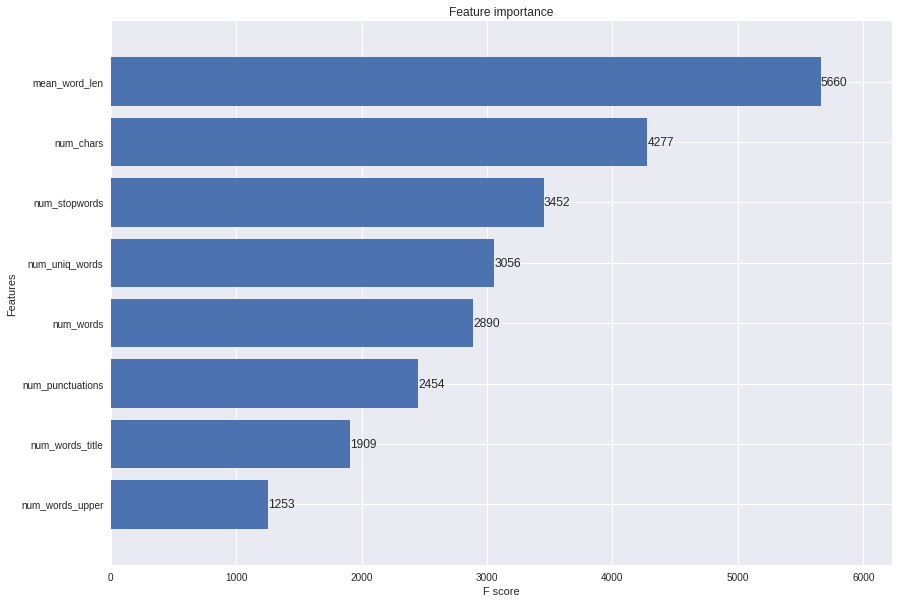

In [157]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(14,10))
xgb.plot_importance(xg_model,  height=0.8, ax=ax)
plt.show()

#  Submit prediction for unseen dataset

In [51]:
y_pred = pred_test_full/3
submit = pd.DataFrame(test['id'])
submit = submit.join(pd.DataFrame(y_pred))
submit.columns = ['id','EAP','HPL','MWS'] 
submit.to_csv('spooky_pred.csv.gz',index=False,compression='gzip')
#submit.to_csv('spooky_pred3.csv',index=False)